In [1]:
# %load imports.ipy
# Stdlib
from functools import partial
from itertools import chain
from pprint import pprint as print

import numpy as np
import pandas as pd

pd.set_option('display.max_columns',102)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width',120)
import sklearn
print(f'numpy {np.__version__} pandas {pd.__version__} sklearn {sklearn.__version__}')

# Visualization

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

custom_style = {'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white', }
sns.set_style( rc=custom_style)
mpl.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.figsize']=(10,10)
jtplot.style('monokai')
# Custom stuff
from swozny_ml import *
from genetic.parameter_optimization import tune_params_genetic
from math import ceil

'numpy 1.13.3 pandas 0.20.3 sklearn 0.19.0'


/home/swozny/untitled5/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Config

In [2]:
filename = 'datasets/kobe.csv'
index = 'shot_id'
target = 'shot_made_flag'
data = pd.read_csv(filename, index_col=index)

In [3]:
# Read data
def quantize(data,col,bins):
    _data=data[col].astype('category')
    col_map=pd.qcut(data.groupby(col).mean()[target].sort_values(),bins)
    return _data.map(col_map).cat.codes

In [4]:
data['Angle']=np.rad2deg(np.arctan(data.loc_y/data.loc_x).fillna(0))
data['Distance']=np.sqrt(data.loc_y**2+data.loc_x**2)
data['Angle']=pd.np.digitize(data.Angle,bins=[-91,-86,-5,5,86,91]).astype('int')
data['Distance']=pd.np.digitize(data.Distance,bins=[-1,1,5,15]).astype('int')
data['minutes_remaining']=pd.np.digitize(data.minutes_remaining,bins=[-1,1,5,11,15]).astype('int')
data['seconds_remaining']=pd.np.digitize(data.minutes_remaining,bins=[2,65]).astype('int')
data['period']=quantize(data,'period',4)
data['weekday']=pd.to_datetime(data['game_date']).dt.weekday
data['month']=pd.to_datetime(data['game_date']).dt.month
data['year']=pd.to_datetime(data['game_date']).dt.year
data['home']=data['matchup'].str.contains('vs').astype('int')
data=data.drop(['loc_x','loc_y','lat','lon','team_id','team_name','matchup','shot_distance','playoffs','combined_shot_type','game_id','game_date','shot_zone_range','game_event_id'],axis=1)
print(data.head())

               action_type  minutes_remaining  period   season  seconds_remaining  shot_made_flag       shot_type  \
shot_id                                                                                                             
1        Jump Shot          3                  3       2000-01  1                 NaN              2PT Field Goal   
2        Jump Shot          3                  3       2000-01  1                  0.0             2PT Field Goal   
3        Jump Shot          3                  3       2000-01  1                  1.0             2PT Field Goal   
4        Jump Shot          3                  3       2000-01  1                  0.0             2PT Field Goal   
5        Driving Dunk Shot  3                  1       2000-01  1                  1.0             2PT Field Goal   

                shot_zone_area  shot_zone_basic opponent  Angle  Distance  weekday  month  year  home  
shot_id                                                                     

## Categorical

In [5]:
# Categorical
categorical = data.select_dtypes(exclude=[np.number])
for col in categorical:
    data[col]=data[col].astype('category')
def quantize(data,col,bins):
    _data=data[col].astype('category')
    col_map=pd.qcut(data.groupby(col).mean()[target].sort_values(),bins)
    return _data.map(col_map).cat.codes
    
categorical = data.select_dtypes(exclude=[np.number])
data['season']=quantize(data,'season',4)
data['shot_zone_area']=quantize(data,'season',3)
data['opponent']=quantize(data,'opponent',4)

data['action_type']=data['action_type'].replace(['Cutting Finger Roll Layup Shot', 'Turnaround Fadeaway Bank Jump Shot'],['Finger Roll Layup Shot','Fadeaway Bank shot'])
data['action_type']=quantize(data,'action_type',8)
categorical = data.select_dtypes(exclude=[np.number])
categorical.describe()

,shot_type,shot_zone_basic
count,30697,30697
unique,2,7
top,2PT Field Goal,Mid-Range
freq,24271,12625


## Numerical

In [6]:
numerical = data.select_dtypes(include=[np.number])
numerical.describe()

,action_type,minutes_remaining,period,season,seconds_remaining,shot_made_flag,shot_zone_area,opponent,Angle,Distance,weekday,month,year,home
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,1.070691,2.441737,1.560348,1.762778,0.874059,0.446161,0.893508,1.688308,3.071342,3.468971,3.266280,5.578460,2006.098446,0.487214
std,1.852495,0.787081,1.116554,1.006600,0.331788,0.497103,0.816075,1.072978,0.950011,1.127070,1.985314,4.155881,4.835462,0.499845
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1996.000000,0.000000
25%,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,4.000000,1.000000,2.000000,2002.000000,0.000000
50%,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,2.000000,3.000000,4.000000,3.000000,4.000000,2006.000000,0.000000
75%,2.000000,3.000000,3.000000,3.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.000000,11.000000,2010.000000,1.000000
max,7.000000,4.000000,3.000000,3.000000,1.000000,1.000000,2.000000,3.000000,5.000000,4.000000,6.000000,12.000000,2016.000000,1.000000


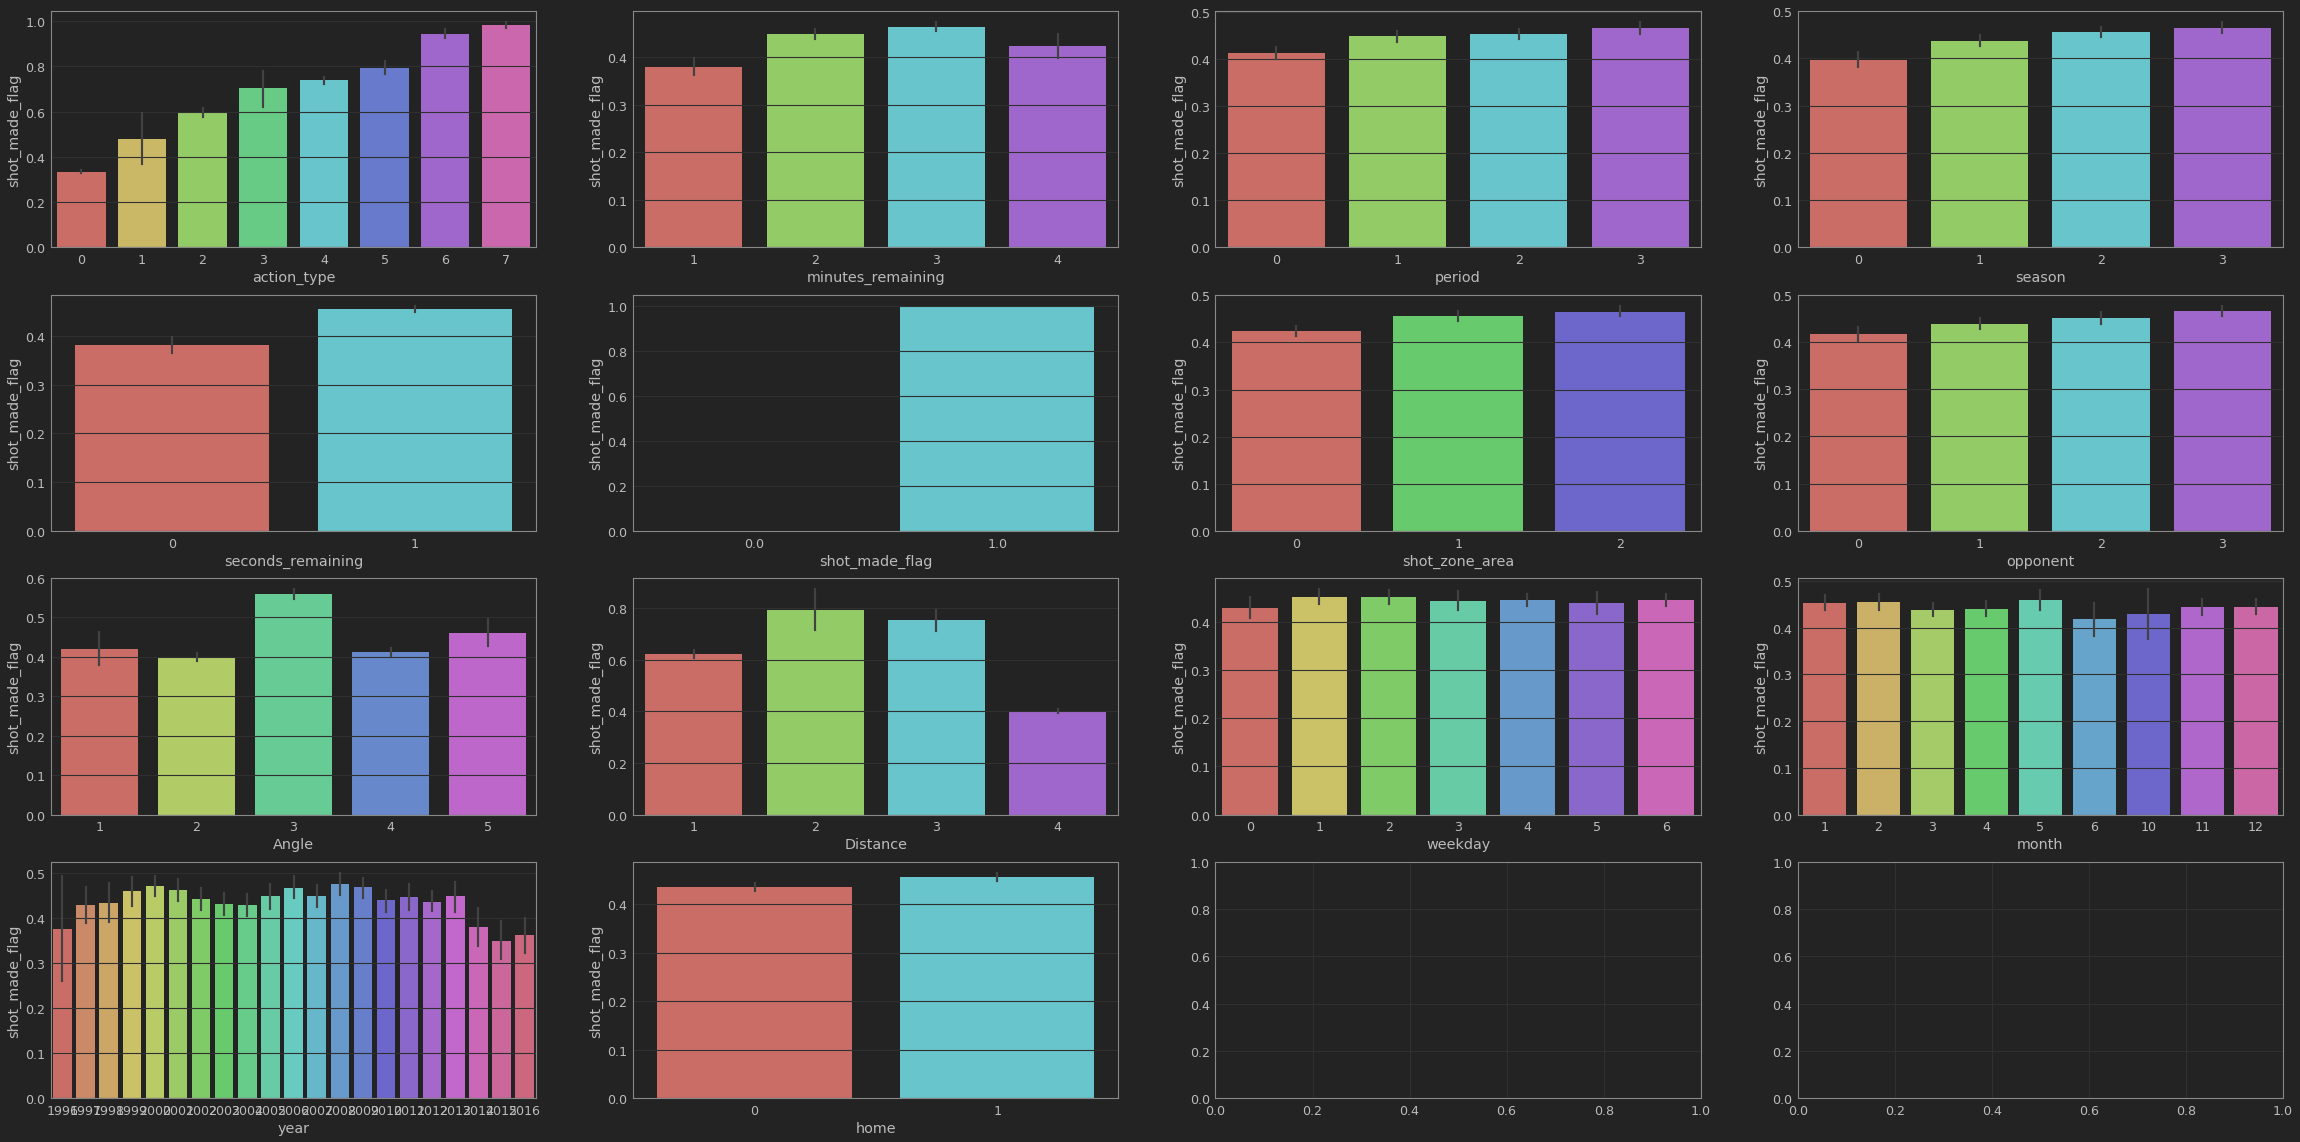

In [7]:
fig, ax = plt.subplots(ncols=4,nrows=ceil(len(numerical.columns)/4),figsize=(40,20))
for col,ax in zip(numerical.columns,chain(*ax)):
    if len(data[col].unique())<60:
        sns.factorplot(data=data,x=col,y='shot_made_flag',ax=ax,kind='bar',palette='hls')
        plt.close(2)
    else:
        g=sns.distplot(data[data[target]==0][col],ax=ax,color='grey')
        sns.distplot(data[data[target]==1][col],color='green',ax=ax)

In [8]:
_data=data.drop(['shot_made_flag','month','weekday','year'],axis=1)
for col in _data:
    _data[col]=_data[col].astype('category')
_data=pd.get_dummies(_data,drop_first=True)
_data['shot_made_flag']=data.shot_made_flag
data=_data

In [9]:
data.to_csv('datasets/preprocessed_kobe.csv')
data

,action_type_1,action_type_2,action_type_3,action_type_4,action_type_5,action_type_6,action_type_7,minutes_remaining_2,minutes_remaining_3,minutes_remaining_4,period_1,period_2,period_3,season_1,season_2,season_3,seconds_remaining_1,shot_type_3PT Field Goal,shot_zone_area_1,shot_zone_area_2,shot_zone_basic_Backcourt,shot_zone_basic_In The Paint (Non-RA),shot_zone_basic_Left Corner 3,shot_zone_basic_Mid-Range,shot_zone_basic_Restricted Area,shot_zone_basic_Right Corner 3,opponent_1,opponent_2,opponent_3,Angle_2,Angle_3,Angle_4,Angle_5,Distance_2,Distance_3,Distance_4,home_1,shot_made_flag
shot_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,NaN
2,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0.0
3,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1.0
4,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0.0
5,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1.0
6,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0.0
7,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1.0
8,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,NaN
9,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1.0


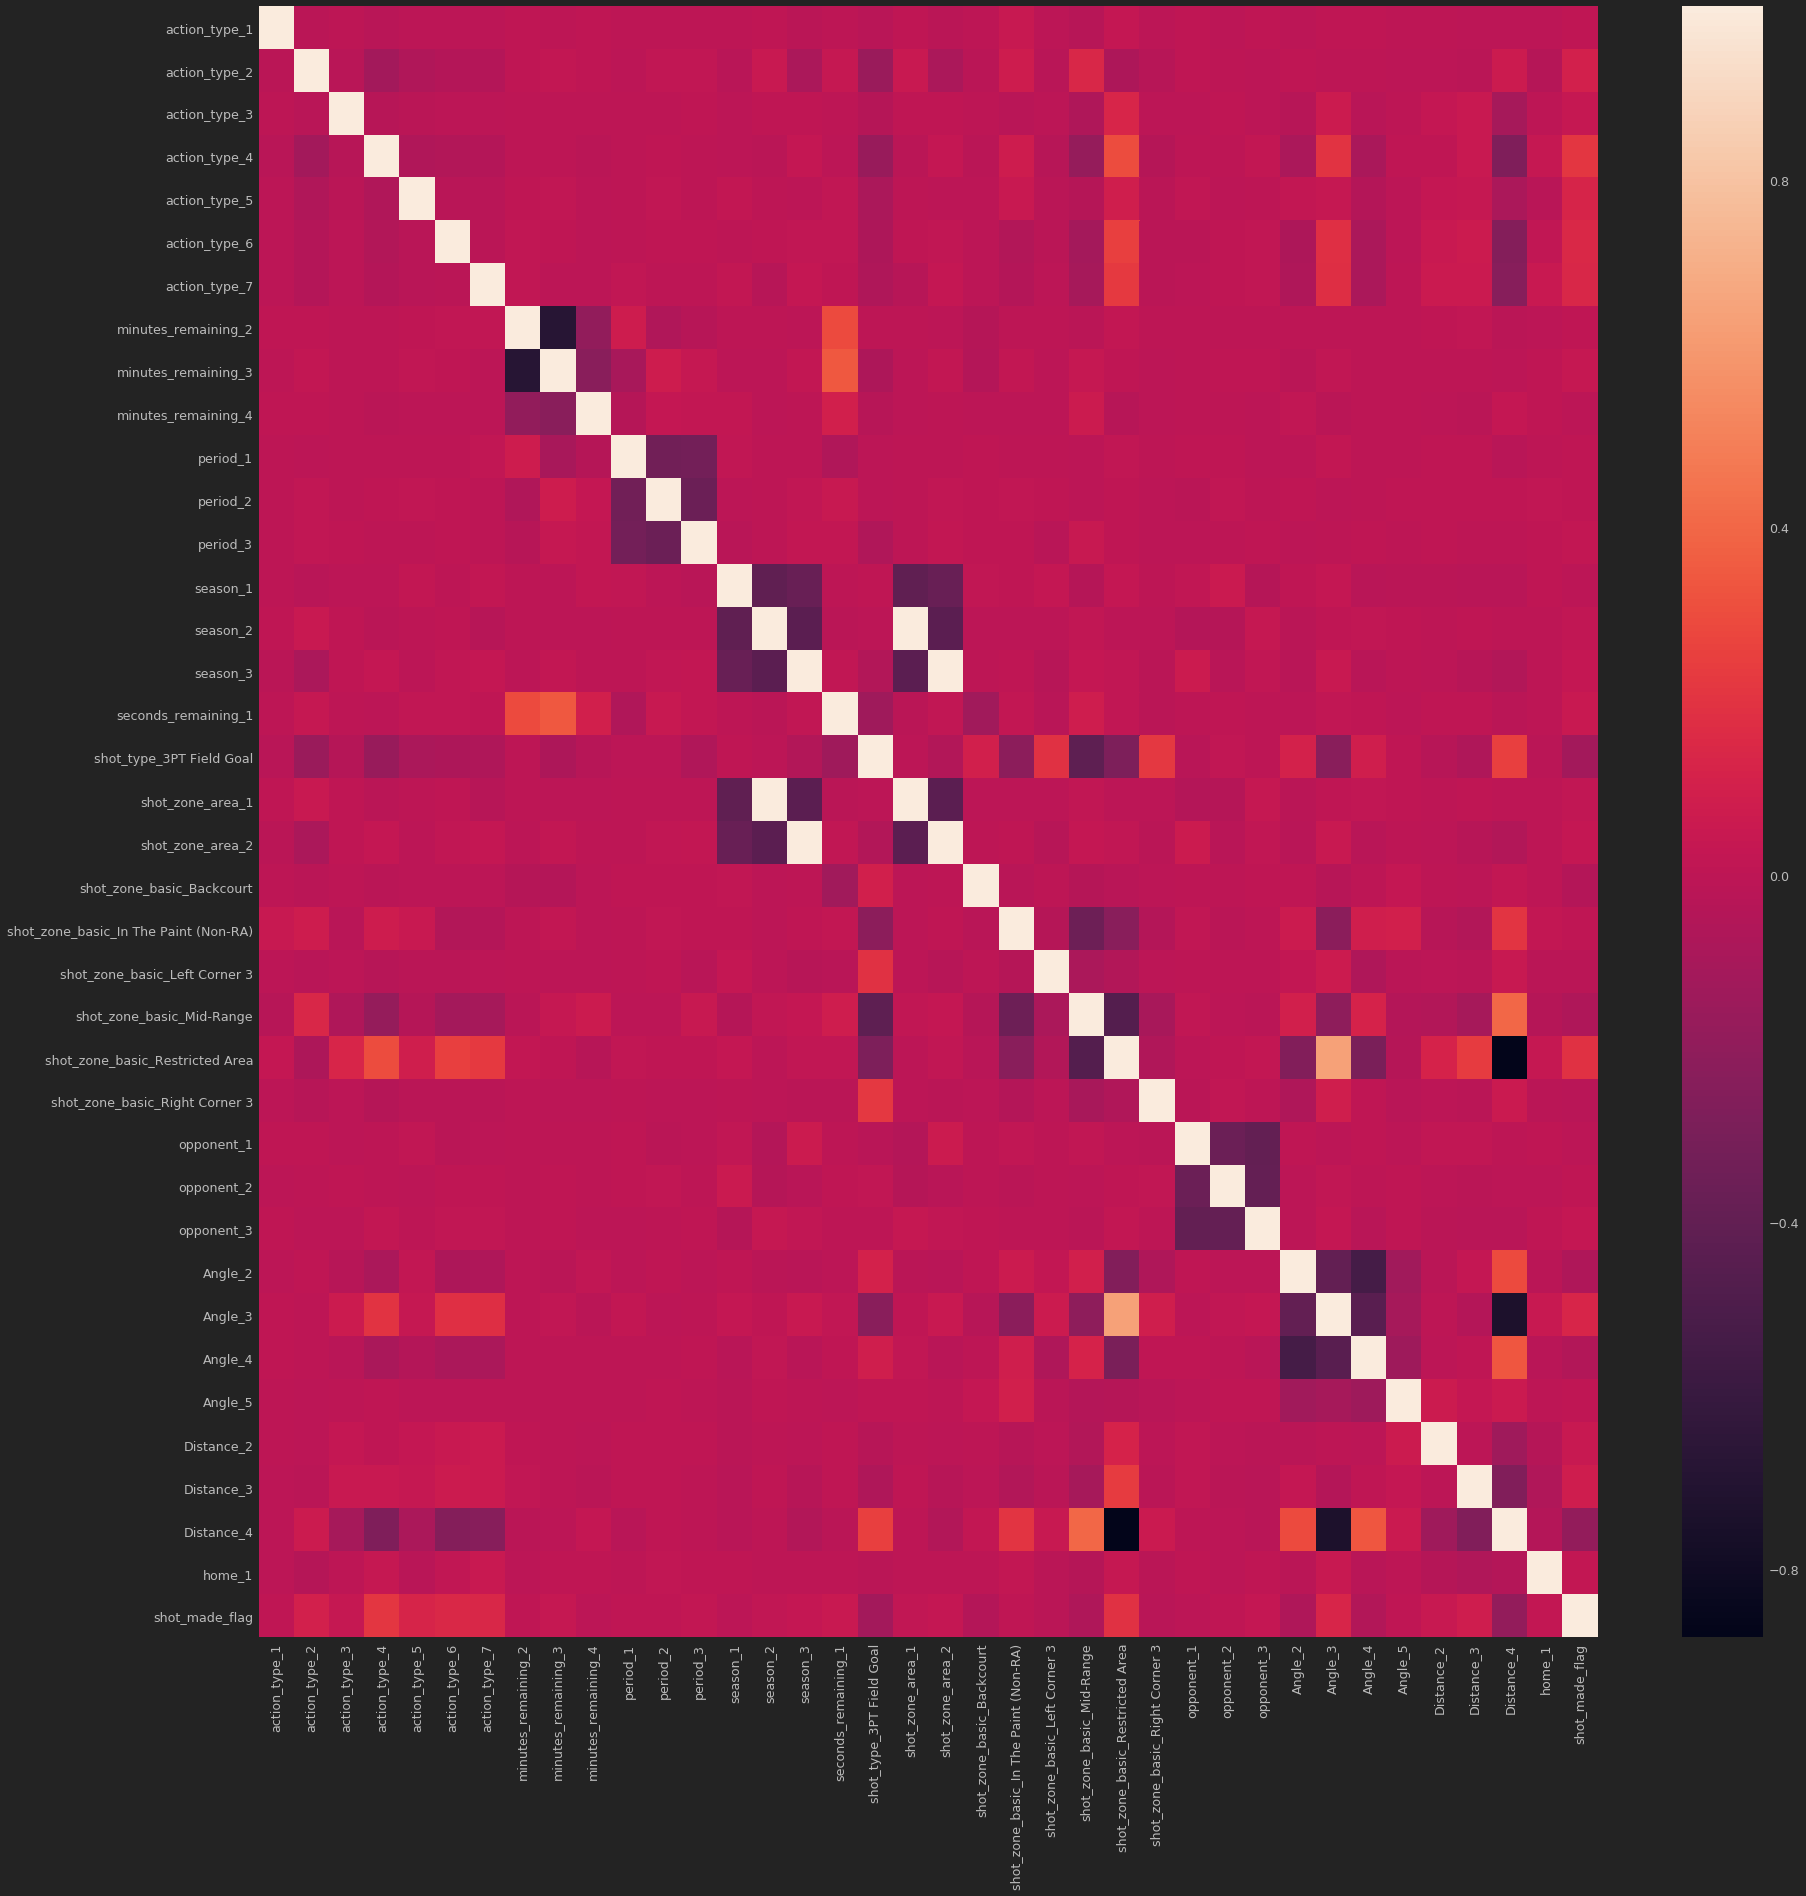

In [10]:
plt.figure(figsize=(30,30))
sns.heatmap(data.corr())